# Estimating the Effect of Cannabis Legalization on Labour Productivity in Canada using the Synthetic Control Method
## Replication Code
Authors: Roa’a Hamed and Khushi Shah

# 1. Load Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy
from warnings import filterwarnings
from scpi_pkg.scdata import scdata
from scpi_pkg.scdataMulti import scdataMulti
from scpi_pkg.scest import scest
from scpi_pkg.scpi import scpi
from scpi_pkg.scplot import scplot
from scpi_pkg.scplotMulti import scplotMulti
from sklearn.preprocessing import StandardScaler
import plotly.express as px
filterwarnings("ignore")

np.random.seed(21) # Set seed for inference

# 2. Prepare Data

In [4]:
# Load Data
data = pd.read_csv("/Users/khushishah/Dropbox/ECON 526 - Project/Final Submission/scm_dataset.csv")
data['year'] = pd.to_numeric(data['year'], errors='coerce').astype('Int64')

# Scale Variables 
scalers = {} # Create a dictionary to store a specific scaler for each feature

# List of features to be scaled
features = ['investment', 'exports', 'imports','industry', 'agriculture',  'inflation', 'popgrowth', 'educ', 'productivity']

# Loop through each feature to scale them individually
for feature in features:
    # 1. Create a new scaler instance for this specific feature
    scalers[feature] = StandardScaler()
    
    # 2. Fit and transform using that specific scaler
    data[feature + '_scaled'] = scalers[feature].fit_transform(data[[feature]])

# List of scaled features
features_scaled = [feature + '_scaled' for feature in features] # List of scaled features

# List of control units
unit_co = list(set(data['country'].to_list()))

# Units to drop from the donor pool
drop_code = ["USA", # legalized cannabis at various state levels during the pre-treatment period
            "NLD", # decriminalized cannabis
            "CAN"] # treated unit


## 2.1 Visualize data

In [5]:
# Plot productivity over time by country
## Ireland (IRL) appears to have an unusual spike in productivity around 2015, which may need further investigation.
fig = px.line(data, x='year', y='productivity', color='country', hover_name='country')
fig.update_layout(height=700, legend=dict(orientation='h'))
fig.show()

# 3. Covariate selection

We run various sets of covariates using synthetic control. We split the pre-treatment period in half - a training period and a validation period - to see which set of covariates better predicts the productivity of Canada in the training period. We then use the covariates set that has the best fit for the actual synthetic control with the full data, using the actual post-treatment period.

## Set 1: Productivity, Industry, Exports

-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)


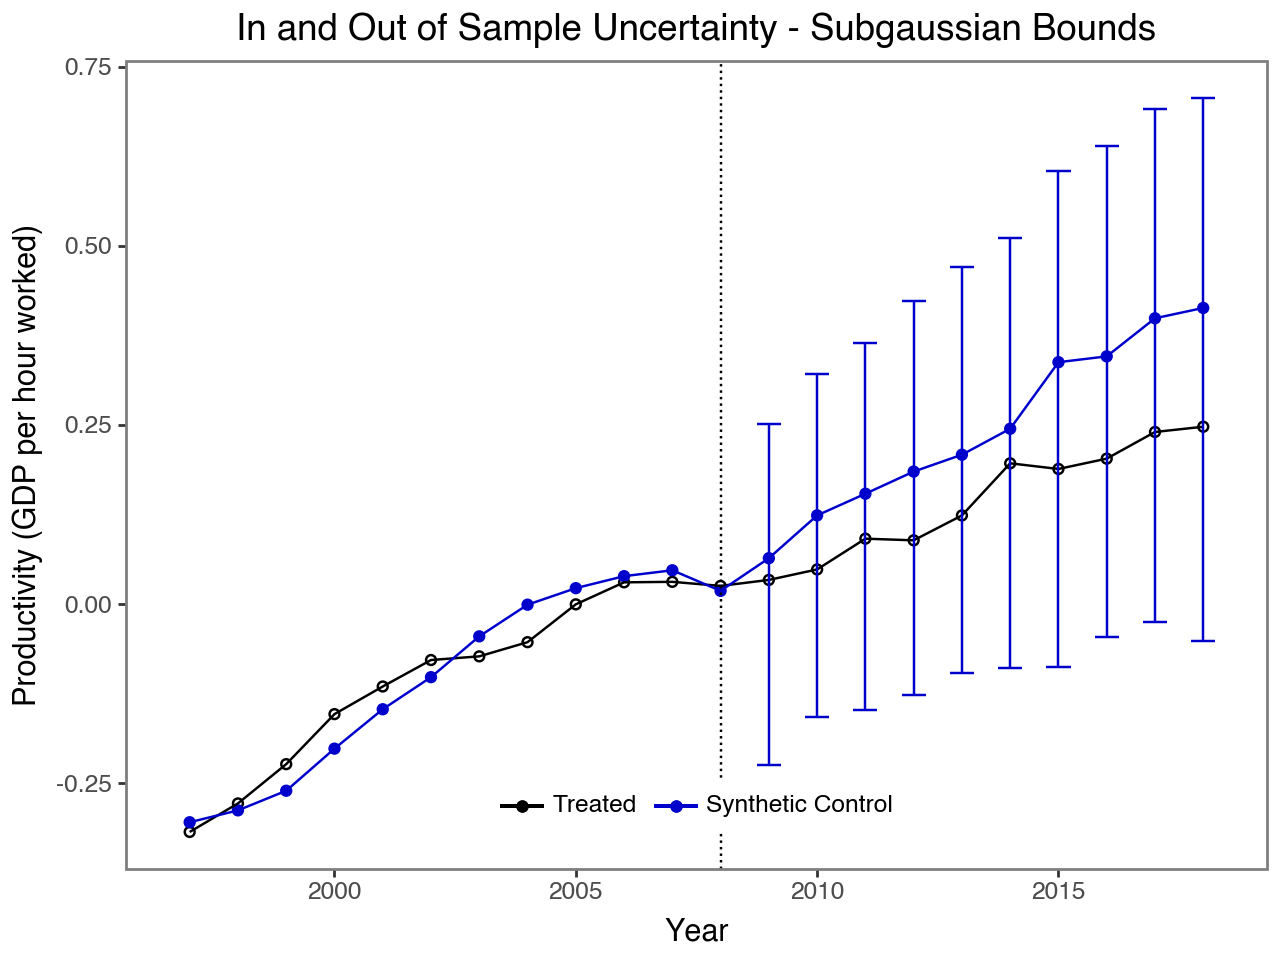

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                                simplex
Constraint Size (Q):                                                  1
Treated Unit:                                                       CAN
Size of the donor pool:                                              35
Features                                                              3
Pre-treatment period                                          1997-2008
Pre-treatment periods used in estimation per feature:
            Feature  Observations
     exports_scaled            12
    industry_scaled            12
productivity_scaled            12
Covariates used for adjustment per feature:
            Feature  Num of Covariates
     exports_scaled                  0
    industry_scaled                  0
productivity_scaled                  0

Synthetic Control Estimation - Results

Active donors: 

In [6]:

# dividing pretreatment data into ~ half, using first half to test features and see how second half of the pre-treatment (i.e, post treatment in this case) performs; helps us see which features to keep.
data_covariates = data[(data["year"] >= 1997) & (data["year"] <= 2019)]

# Set options for data preparation
id_var = 'country'
outcome_var = 'productivity_scaled'
time_var = 'year'
features = ['productivity_scaled', 'industry_scaled', 'exports_scaled']
cov_adj = None
period_pre = np.arange(1997, 2009)
period_post = np.arange(2009, 2019)
unit_tr = 'CAN'
unit_co= unit_co = [cou for cou in unit_co if cou not in drop_code]
constant = False
cointegrated_data = True

data_prep = scdata(df=data_covariates, id_var=id_var, time_var=time_var,
                   outcome_var=outcome_var, period_pre=period_pre,
                   period_post=period_post, unit_tr=unit_tr,
                   unit_co=unit_co, features=features, cov_adj=cov_adj,
                   cointegrated_data=cointegrated_data, constant=constant)



# Set options for inference
w_constr = {'name': 'simplex', 'Q': 1}
u_missp = True
u_sigma = "HC1"
u_order = 1
u_lags = 0
e_method = "gaussian"
e_order = 1
e_lags = 0
e_alpha = 0.05
u_alpha = 0.05
sims = 1000
cores = 1

pi_simplex = scpi(data_prep, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
             e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
             u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)


# SC - plot results
plot = scplot(pi_simplex, x_lab = "Year", y_lab = "Productivity (GDP per hour worked)")
plot.show()

# SC - point estimation with simplex
est_simplex = scest(data_prep, w_constr={'name': "simplex"})
print(est_simplex)
# SC - plot results - Simplex
plot = scplot(est_simplex)
print(pi_simplex)


## Set 2: Productivity and Population Growth

-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)


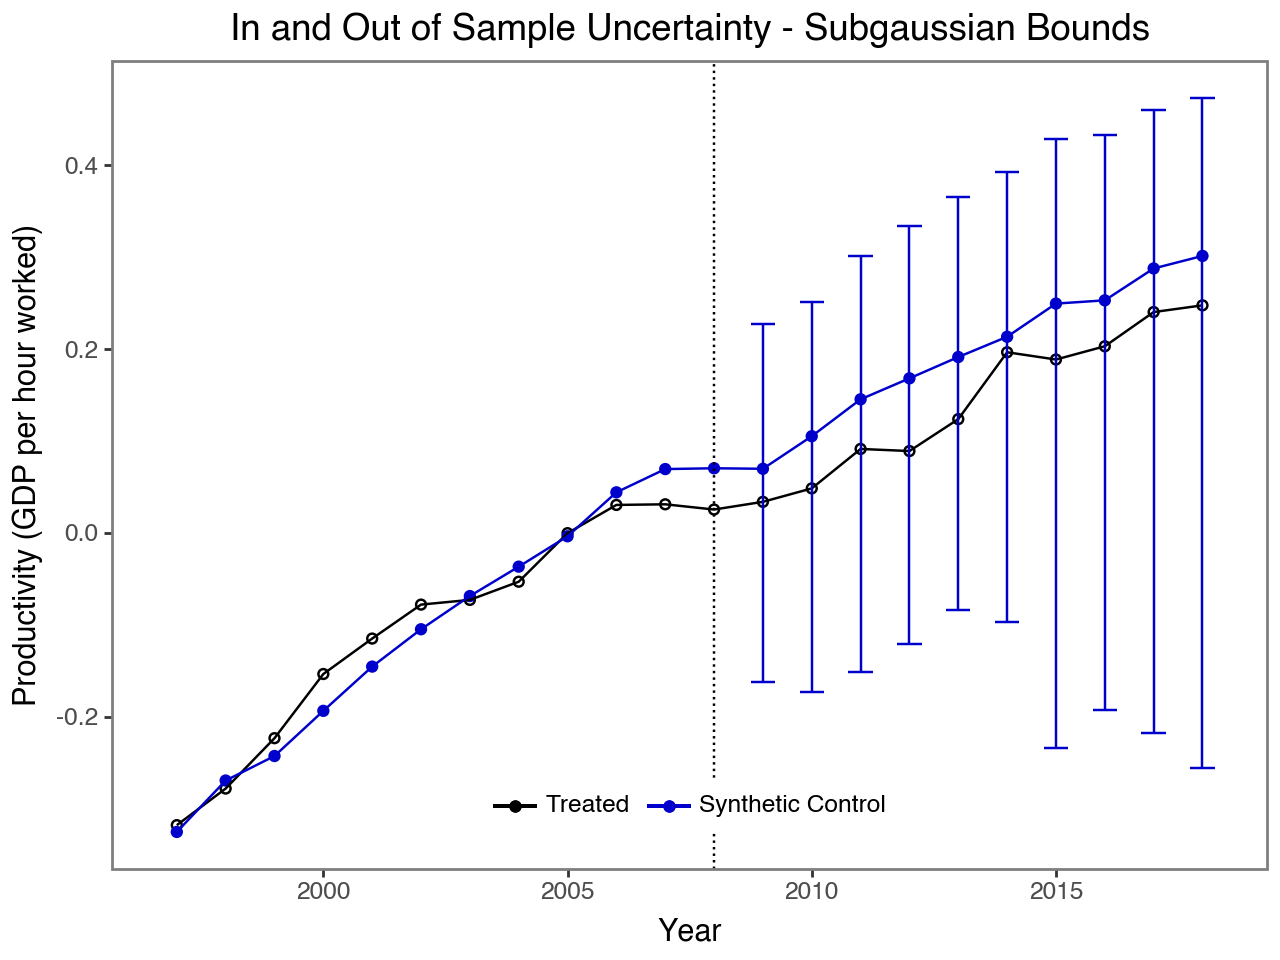

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                                simplex
Constraint Size (Q):                                                  1
Treated Unit:                                                       CAN
Size of the donor pool:                                              35
Features                                                              2
Pre-treatment period                                          1997-2008
Pre-treatment periods used in estimation per feature:
            Feature  Observations
   popgrowth_scaled            12
productivity_scaled            12
Covariates used for adjustment per feature:
            Feature  Num of Covariates
   popgrowth_scaled                  0
productivity_scaled                  0

Synthetic Control Estimation - Results

Active donors: 12

Coefficients:
                    Weights
Treated Unit Donor         

In [7]:
# Set options for data preparation
id_var = 'country'
outcome_var = 'productivity_scaled'
time_var = 'year'
features = ['popgrowth_scaled', 'productivity_scaled']
cov_adj = None
period_pre = np.arange(1997, 2009)
period_post = np.arange(2009, 2019)
unit_tr = 'CAN'
unit_co= unit_co = [cou for cou in unit_co if cou not in drop_code]
constant = False
cointegrated_data = True

data_prep = scdata(df=data, id_var=id_var, time_var=time_var,
                   outcome_var=outcome_var, period_pre=period_pre,
                   period_post=period_post, unit_tr=unit_tr,
                   unit_co=unit_co, features=features, cov_adj=cov_adj,
                   cointegrated_data=cointegrated_data, constant=constant)


# Set options for inference
w_constr = {'name': 'simplex', 'Q': 1}
u_missp = True
u_sigma = "HC1"
u_order = 1
u_lags = 0
e_method = "gaussian"
e_order = 1
e_lags = 0
e_alpha = 0.05
u_alpha = 0.05
sims = 1000
cores = 1

pi_simplex = scpi(data_prep, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
             e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
             u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)


# SC - plot results
plot = scplot(pi_simplex, x_lab = "Year", y_lab = "Productivity (GDP per hour worked)")
plot.show()

# SC - point estimation with simplex
est_simplex = scest(data_prep, w_constr={'name': "simplex"})
print(est_simplex)
# SC - plot results - Simplex
plot = scplot(est_simplex)
print(pi_simplex)


## Set 3: Productivity, Investment, Industry

-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)


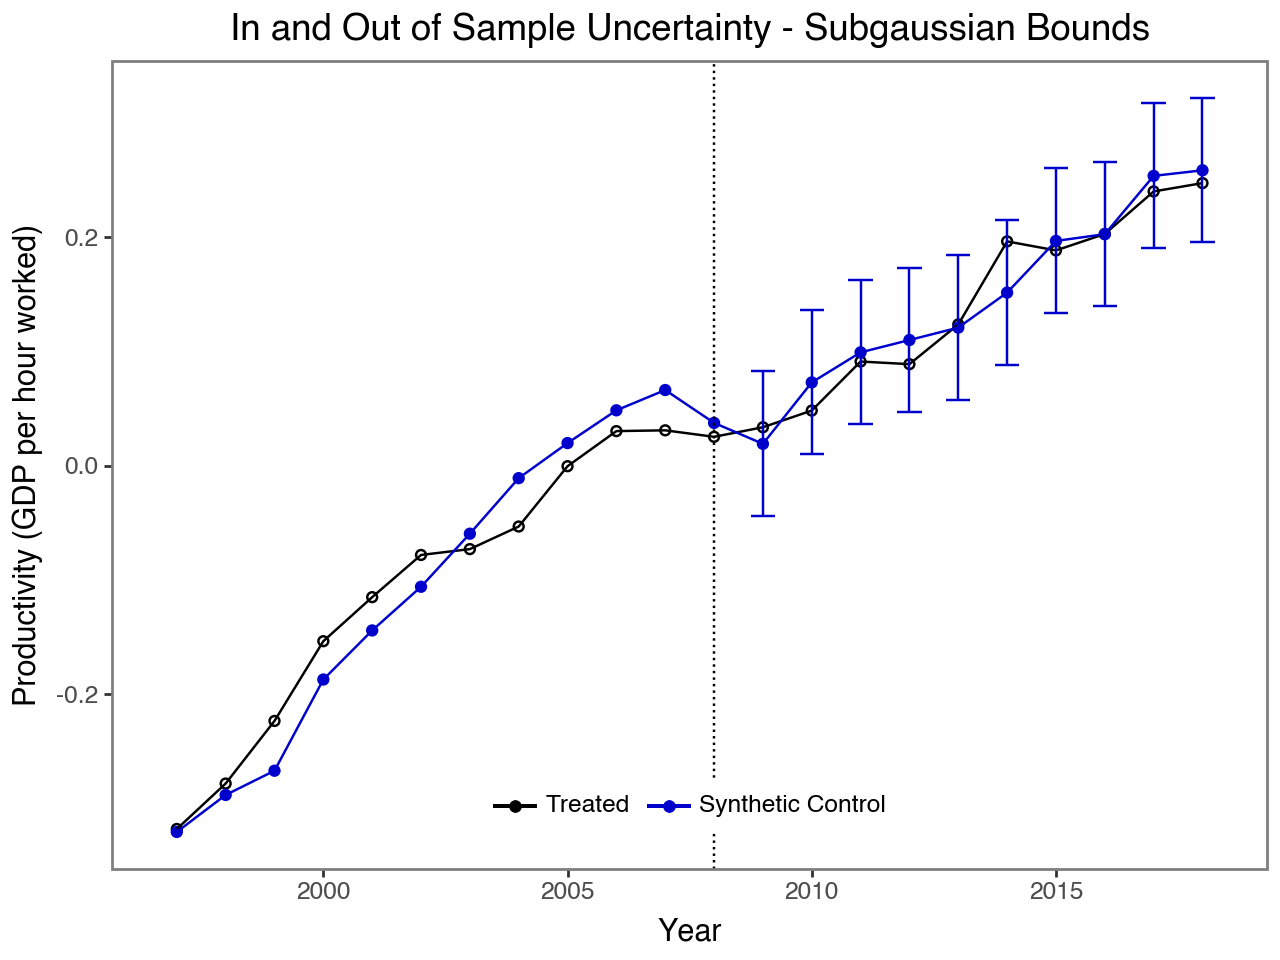

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                                simplex
Constraint Size (Q):                                                  1
Treated Unit:                                                       CAN
Size of the donor pool:                                              35
Features                                                              3
Pre-treatment period                                          1997-2008
Pre-treatment periods used in estimation per feature:
            Feature  Observations
    industry_scaled            12
  investment_scaled            12
productivity_scaled            12
Covariates used for adjustment per feature:
            Feature  Num of Covariates
    industry_scaled                  0
  investment_scaled                  0
productivity_scaled                  0

Synthetic Control Estimation - Results

Active donors: 

In [8]:
# Set options for data preparation
id_var = 'country'
outcome_var = 'productivity_scaled'
time_var = 'year'
features = ['investment_scaled', 'industry_scaled','productivity_scaled']
cov_adj = None
period_pre = np.arange(1997, 2009)
period_post = np.arange(2009, 2019)
unit_tr = 'CAN'
unit_co= unit_co = [cou for cou in unit_co if cou not in drop_code]
constant = False
cointegrated_data = True

data_prep = scdata(df=data, id_var=id_var, time_var=time_var,
                   outcome_var=outcome_var, period_pre=period_pre,
                   period_post=period_post, unit_tr=unit_tr,
                   unit_co=unit_co, features=features, cov_adj=cov_adj,
                   cointegrated_data=cointegrated_data, constant=constant)


# Set options for inference
w_constr = {'name': 'simplex', 'Q': 1}
u_missp = True
u_sigma = "HC1"
u_order = 1
u_lags = 0
e_method = "gaussian"
e_order = 1
e_lags = 0
e_alpha = 0.05
u_alpha = 0.05
sims = 1000
cores = 1

pi_simplex = scpi(data_prep, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
             e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
             u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)


# SC - plot results
plot = scplot(pi_simplex, x_lab = "Year", y_lab = "Productivity (GDP per hour worked)")
plot.show()

# SC - point estimation with simplex
est_simplex = scest(data_prep, w_constr={'name': "simplex"})
print(est_simplex)
# SC - plot results - Simplex
plot = scplot(est_simplex)
print(pi_simplex)

## Set 4: Only productivity

-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)


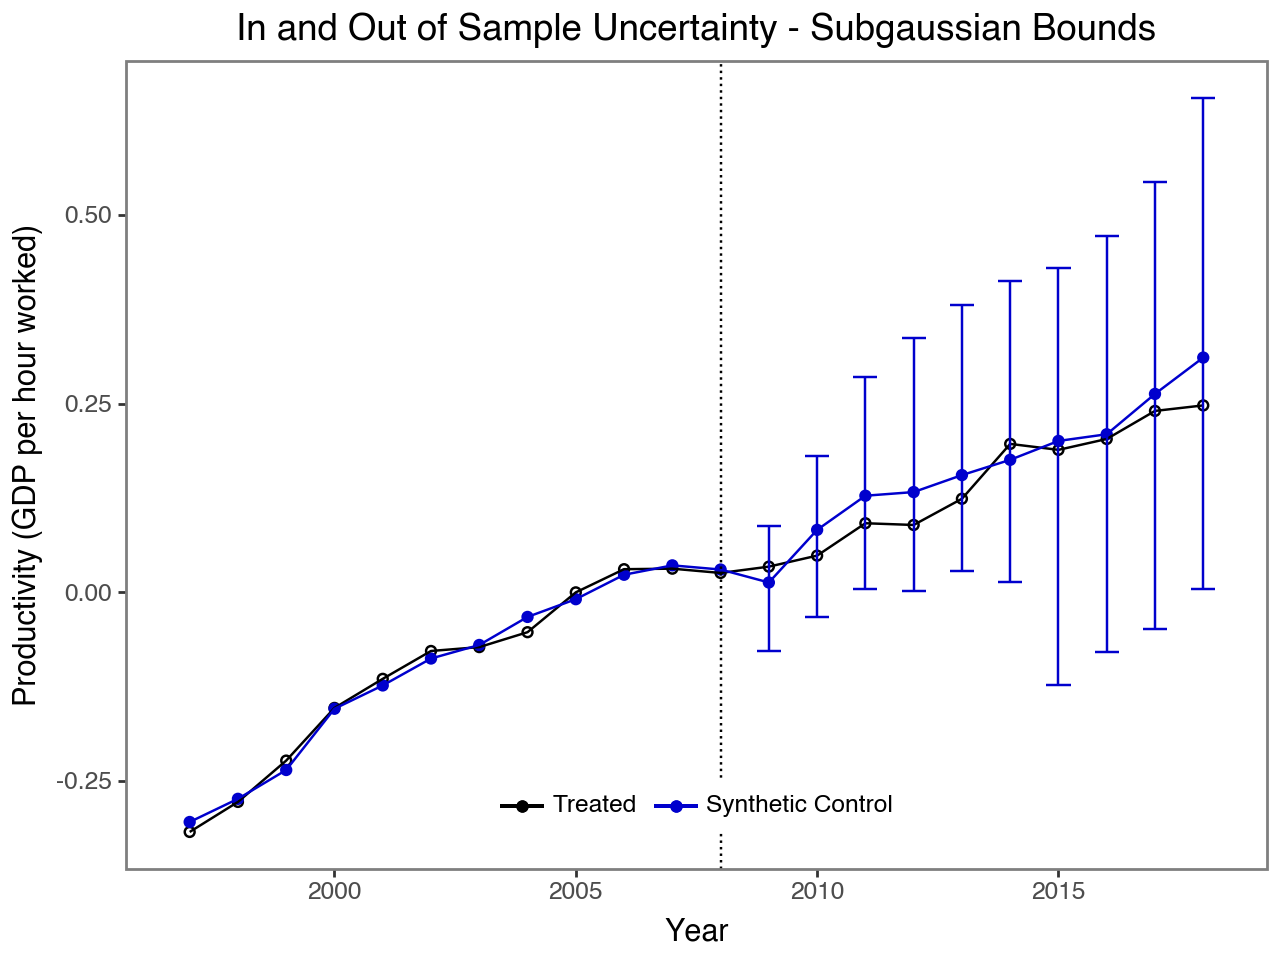

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                           simplex
Constraint Size (Q):                                             1
Treated Unit:                                                  CAN
Size of the donor pool:                                         35
Features                                                         1
Pre-treatment period                                     1997-2008
Pre-treatment periods used in estimation:                       12
Covariates used for adjustment:                                  0

Synthetic Control Estimation - Results

Active donors: 5

Coefficients:
                    Weights
Treated Unit Donor         
CAN          AUS      0.000
             AUT      0.045
             BEL      0.000
             BGR      0.000
             CHE      0.000
             COL      0.000
             CRI      0.000
             CZE 

In [9]:
# Set options for data preparation
id_var = 'country'
outcome_var = 'productivity_scaled'
time_var = 'year'
features = None # implicitly only uses outcome variable as feature
cov_adj = None
period_pre = np.arange(1997, 2009)
period_post = np.arange(2009, 2019)
unit_tr = 'CAN'
unit_co= unit_co = [cou for cou in unit_co if cou not in drop_code]
constant = False
cointegrated_data = True

data_prep = scdata(df=data, id_var=id_var, time_var=time_var,
                   outcome_var=outcome_var, period_pre=period_pre,
                   period_post=period_post, unit_tr=unit_tr,
                   unit_co=unit_co, features=features, cov_adj=cov_adj,
                   cointegrated_data=cointegrated_data, constant=constant)


# Set options for inference
w_constr = {'name': 'simplex'}
u_missp = True
u_sigma = "HC1"
u_order = 1
u_lags = 0
e_method = "gaussian"
e_order = 1
e_lags = 0
e_alpha = 0.05
u_alpha = 0.05
sims = 1000
cores = 1

pi_simplex = scpi(data_prep, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
             e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
             u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)


# SC - plot results
plot = scplot(pi_simplex, x_lab = "Year", y_lab = "Productivity (GDP per hour worked)")
plot.show()

# SC - point estimation with simplex
est_simplex = scest(data_prep, w_constr={'name': "simplex"})
print(est_simplex)
# SC - plot results - Simplex
plot = scplot(est_simplex)
print(pi_simplex)

# Synthetic Control Method 
We used Productivity, Industry and Investment as features. Outcome variable: labour productivity. This method relies on Simplex (sum of weights = 1; all weights >= 0)


-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)


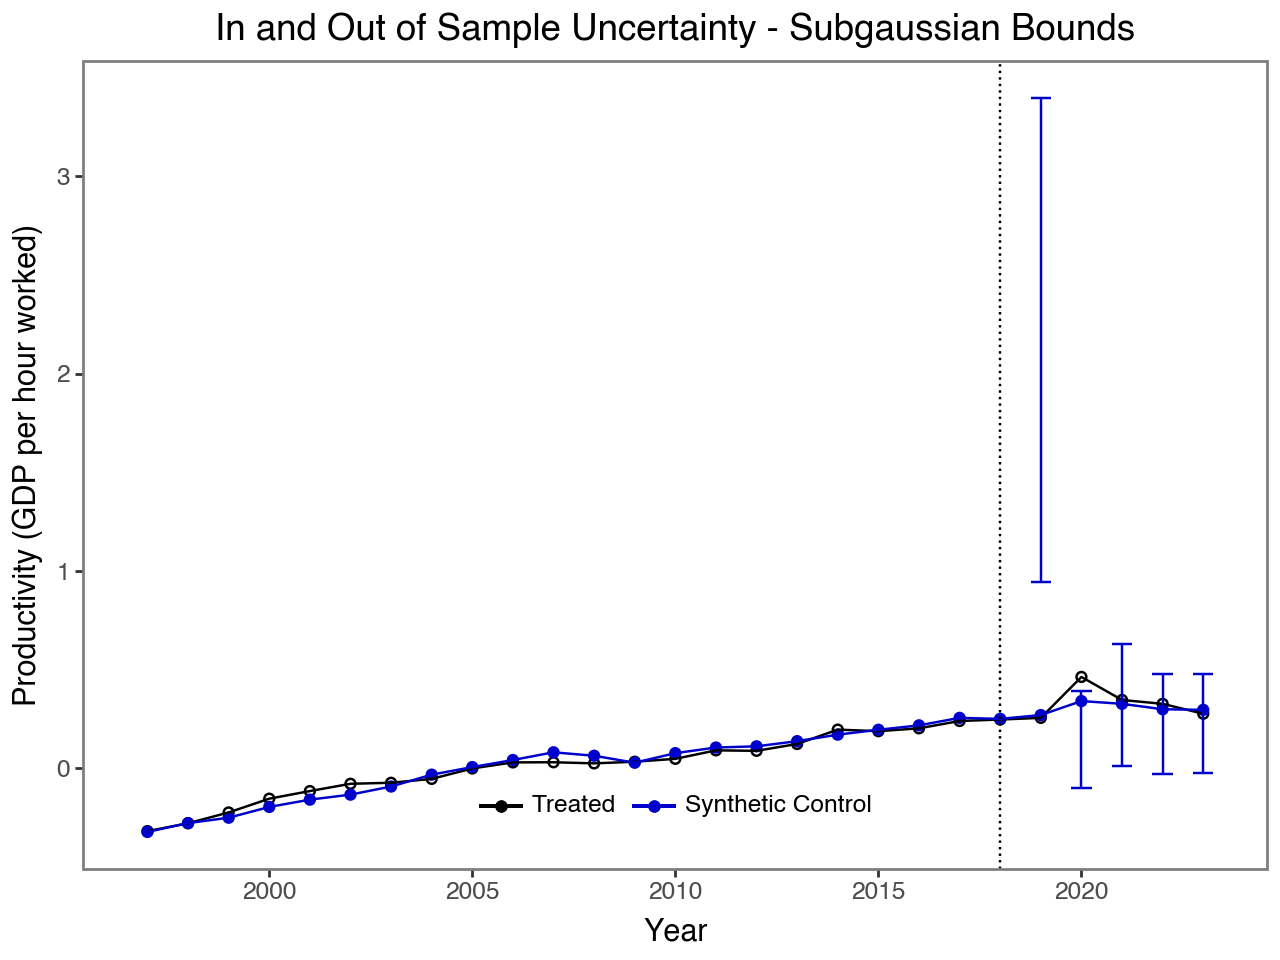

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                                simplex
Constraint Size (Q):                                                  1
Treated Unit:                                                       CAN
Size of the donor pool:                                              35
Features                                                              3
Pre-treatment period                                          1997-2018
Pre-treatment periods used in estimation per feature:
            Feature  Observations
    industry_scaled            22
  investment_scaled            22
productivity_scaled            22
Covariates used for adjustment per feature:
            Feature  Num of Covariates
    industry_scaled                  0
  investment_scaled                  0
productivity_scaled                  0

Synthetic Control Estimation - Results

Active donors: 

In [10]:
# Set options for data preparation
id_var = 'country'
outcome_var = 'productivity_scaled'
time_var = 'year'
features = ['productivity_scaled', 'investment_scaled', 'industry_scaled']
cov_adj = None
period_pre = np.arange(1997, 2019) # pre-treatment period is 1997-2018
period_post = np.arange(2019, 2024) # post-treatment period is 2019-2023
unit_tr = 'CAN'
unit_co= unit_co = [cou for cou in unit_co if cou not in drop_code]
constant = False
cointegrated_data = True

data_prep = scdata(df=data, id_var=id_var, time_var=time_var,
                   outcome_var=outcome_var, period_pre=period_pre,
                   period_post=period_post, unit_tr=unit_tr,
                   unit_co=unit_co, features=features, cov_adj=cov_adj,
                   cointegrated_data=cointegrated_data, constant=constant)

# Set options for inference
w_constr = {'name': 'simplex'}
u_missp = True
u_sigma = "HC1"
u_order = 1
u_lags = 0
e_method = "gaussian"
e_order = 1
e_lags = 0
e_alpha = 0.05
u_alpha = 0.05
sims = 1000
cores = 1

pi_simplex = scpi(data_prep, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
             e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
             u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)


# SC - plot results
plot = scplot(pi_simplex, x_lab = "Year", y_lab = "Productivity (GDP per hour worked)")
plot.show()

# SC - point estimation with simplex
est_simplex = scest(data_prep, w_constr={'name': "simplex"})
print(est_simplex)

# SC - plot results - Simplex
plot = scplot(est_simplex)
print(pi_simplex)

# Permutation Inference

## Extract treatment effects between Canada and the synthetic unit

In [11]:
# raw predictions from the model we ran above
sc_results_simplex = np.concatenate([est_simplex.Y_pre_fit, est_simplex.Y_post_fit]).reshape(-1, 1).flatten()

# inverse transform: transform to scaler, then transform back to oroginal scale
sc_original = scalers['productivity'].inverse_transform(
    np.concatenate([est_simplex.Y_pre_fit, est_simplex.Y_post_fit]).reshape(-1, 1)
).flatten()

# results dataframe
synth_results = pd.DataFrame({
    'year': list(est_simplex.period_pre) + list(est_simplex.period_post),
    'synthetic_control': sc_original, 
    'synthetic_control_scaled': sc_results_simplex
})

# Merge back to main data
data = pd.merge(data, synth_results, on=['year'], how='left')

# Calculate the placebo effect in original scale
# The impact of the cannabis policy = difference between actual productivity and synthetic control productivity
data['treatment_effect'] = data['productivity'] - data['synthetic_control']

# Drop any lingering column named "CAN"
if "CAN" in data.columns:
    data = data.drop(columns="CAN")

data["after_treatment"] = data["year"] > 2018

### Print Treatment Effect Table

In [12]:
data_te_ca = data[data['country'] == 'CAN']
data_te_ca = data_te_ca[data_te_ca['after_treatment'] == True]
data_te_ca = data_te_ca[['year', 'country', 'productivity', 'synthetic_control', 'treatment_effect']]
data_te_ca  

,year,country,productivity,synthetic_control,treatment_effect
130,2019,CAN,58.407191,58.716322,-0.309131
131,2020,CAN,62.913768,60.257097,2.656671
132,2021,CAN,60.376378,59.954147,0.422231
133,2022,CAN,59.953622,59.355815,0.597807
134,2023,CAN,58.861748,59.290663,-0.428916


### Plot Gap Plot for Canada

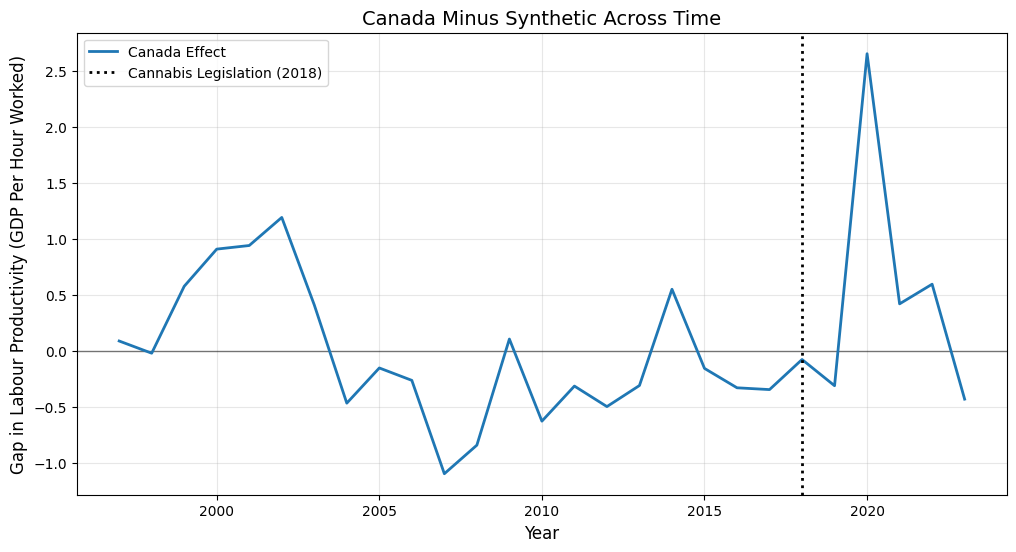

In [13]:
# 1. Filter for Canada
plot_data = data[data['country'] == 'CAN']

plt.figure(figsize=(12, 6))

# 2. Zero Line (Baseline where Actual = Synthetic)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# 3. Plot the Gap (Treatment Effect)
plt.plot(plot_data['year'], plot_data['treatment_effect'], 
         color='tab:blue', linewidth=2, label="Canada Effect")


# 5. Intervention Line
plt.axvline(x=2018, color='black', linestyle=':', linewidth=2, label= "Cannabis Legislation (2018)")

# Formatting
plt.title("Canada Minus Synthetic Across Time", fontsize=14)
plt.ylabel("Gap in Labour Productivity (GDP Per Hour Worked)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)

plt.show()

## Run placebo tests
Act as if untreated donor was treated and construct a synthetic control using the rest of the donors. Then measure the difference in productivity between them to get the placebo effect.

### Calculating Placebo effects

In [14]:
# This code was generated with help from Gemini AI
# creating empty vector to store results
placebo_gaps = []
mspe = []

# Ensure Canada is not in the loop
control_units = [c for c in unit_co if c != 'CAN']

print(f"Running placebo tests on {len(control_units)} countries...")

for country in control_units:
    try:
        # preparing data for canada
        aux = scdata(
            df=data, 
            id_var='country', 
            time_var='year', 
            outcome_var='productivity_scaled', 
            period_pre=period_pre, 
            period_post=period_post, 
            unit_tr=country,  # Pretend THIS country is treated
            unit_co=[c for c in unit_co if c != country], # All others are donors
            features= None, # matching only on productivity
            cointegrated_data=True
        )

        # Estimate Synthetic Control 
        res = scest(aux, w_constr={'name': "simplex"})
        
        #  Extract Results 
        sc_pred_scaled = np.concatenate([res.Y_pre_fit, res.Y_post_fit]).flatten()
        
        # Inverse transform (Using 'productivity' scaler)
        sc_pred = scalers['productivity'].inverse_transform(
            sc_pred_scaled.reshape(-1, 1)
        ).flatten()
        
        # Calculate Gap
        actual = data[data['country'] == country].set_index('year')['productivity']
        years = list(res.period_pre) + list(res.period_post)
        
        df_placebo = pd.DataFrame({
            'year': years,
            'country': country,
            'synthetic': sc_pred
        })
        
        # Map actuals and calc gap
        df_placebo['actual'] = df_placebo['year'].map(actual)
        df_placebo['placebo_effect'] = df_placebo['actual'] - df_placebo['synthetic']
        
        # Calculate Pre-Treatment MSPE 
        pre_data = df_placebo[df_placebo['year'] < 2019]
        mse_pre = np.mean((pre_data['actual'] - pre_data['synthetic'])**2)
        
        placebo_gaps.append(df_placebo)
        

        #  Calculate Post-Treatment MSPE 
        post_data = df_placebo[df_placebo['year'] >= 2019]
        mse_post = np.mean((post_data['actual'] - post_data['synthetic'])**2)

        # Calculate RMSE ratio 
        mspe_ratio = mse_post / mse_pre if mse_pre != 0 else np.nan
       
       # Store MSPEs
        mspe.append({'country': country, 'pre_mse': mse_pre, 'post_mse': mse_post, 'mspe_ratio': mspe_ratio})

    except Exception as e:
        print(f"Skipping {country} due to error: {e}")

# Combine all placebo results
if placebo_gaps:
    all_placebos = pd.concat(placebo_gaps)
    print("Placebo loop complete.")
else:
    print("No placebos were generated successfully.")


Running placebo tests on 35 countries...
Placebo loop complete.


### Calculate MSPEs for Canada

In [15]:
#Canada MSPE
canada_data = data[data['country'] == 'CAN']

pre_tre_can =  canada_data[canada_data['year'] < 2019] # pre-treatment period data
pre_mspe_canada = np.mean((pre_tre_can['productivity'] - pre_tre_can['synthetic_control'])**2) # pre-treatment MSPE

post_tre_can =  canada_data[canada_data['year'] >= 2019] # post-treatment period data
post_mspe_canada = np.mean((post_tre_can['productivity'] - post_tre_can['synthetic_control'])**2) # post-treatment MSPE

# Store Canada's MSPEs
mspe.append({'country': 'CAN', 'pre_mse': pre_mspe_canada, 'post_mse': post_mspe_canada, 'mspe_ratio': post_mspe_canada / pre_mspe_canada})

## Graph Placebo Test Treatment Effects

### Result 1 - All Placebos and Canada (No filtering based on pre-MSPE)

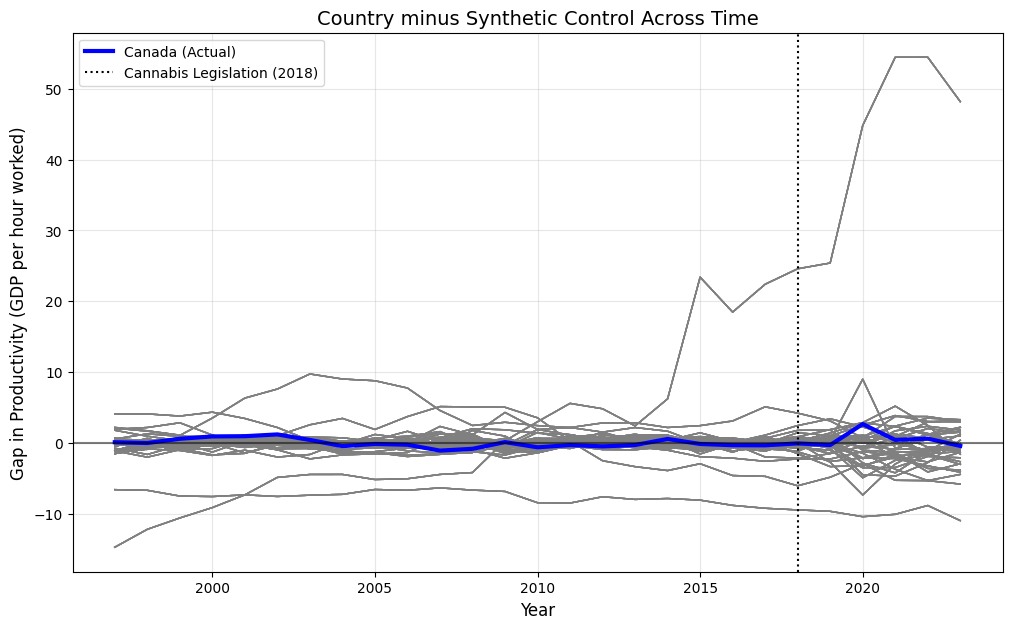

In [16]:
placebo_countries = all_placebos['country']

# Plot Placebos Effects (Grey Lines)
plt.figure(figsize=(12, 7))
for country in placebo_countries:
    subset = all_placebos[all_placebos['country'] == country]
    plt.plot(subset['year'], subset['placebo_effect'], color='grey', alpha=0.2, linewidth=1)

# Plot Canada (Bold Blue)
canada_data = data[data['country'] == 'CAN']
plt.plot(canada_data['year'], canada_data['treatment_effect'], 
         color='blue', linewidth=3, label='Canada (Actual)')


plt.axvline(x=2018, color='black', linestyle=':', label='Cannabis Legislation (2018)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title("Country minus Synthetic Control Across Time", fontsize=14)
plt.ylabel("Gap in Productivity (GDP per hour worked)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


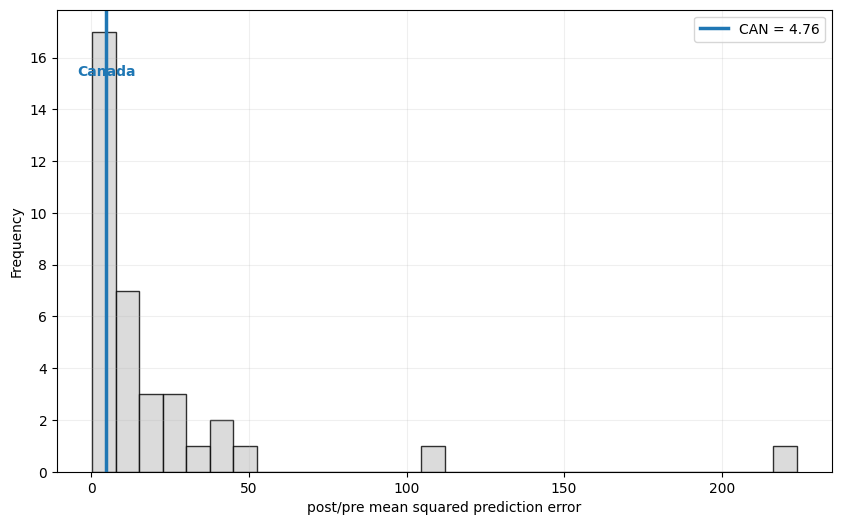

In [17]:
# following Abadie (2010) method here

# mspe as df for further inference
mspe_df = pd.DataFrame(mspe).dropna(subset=['mspe_ratio'])

# Canada's ratio 
can_ratio = mspe_df.loc[mspe_df['country']=='CAN', 'mspe_ratio']
can_ratio = float(can_ratio.iloc[0]) if len(can_ratio) else np.nan

plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(mspe_df['mspe_ratio'], bins=30, color='lightgray', edgecolor='k', alpha=0.8)
if not np.isnan(can_ratio):
    plt.axvline(can_ratio, color='C0', linewidth=2.5, label=f"CAN = {can_ratio:.2f}")
    # annotate near the top of the histogram
    ymax = n.max()
    plt.text(can_ratio, ymax*0.9, 'Canada', color='C0', ha='center', weight='bold')

plt.xlabel('post/pre mean squared prediction error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [18]:
# Canada's MSPE ratio
can_mspe = mspe_df.loc[mspe_df['country'] == 'CAN', 'pre_mse'].iloc[0]

# Median including Canada
median_can = mspe_df['pre_mse'].median()

# Median excluding Canada
median_no_can = mspe_df.loc[mspe_df['country'] != 'CAN', 'pre_mse'].median()

print(f"Canada's Pre MSE: {can_mspe:.3f}")
print(f"Median excluding Canada: {median_no_can:.3f}")



Canada's Pre MSE: 0.331
Median excluding Canada: 0.395


### Result 2 - Filtering Donors with 20x Canada's pre-MSPE 

Number of placebo countries passing 2x MSPE filter: 31


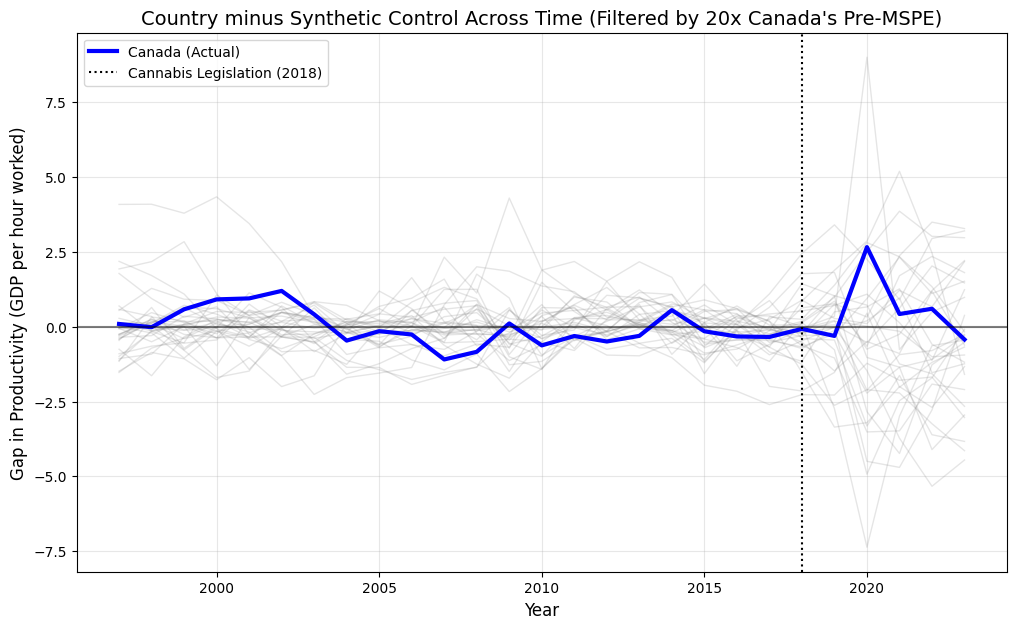

In [19]:
# Filtered by 20x Canada's Pre-MSPE
mspe_threshold = 20 * pre_mspe_canada
filtered20_mspes = mspe_df[mspe_df['pre_mse'] <= mspe_threshold] # Filtered MSPEs whose pre_mse is less than 20 times Canada's pre_mse

# 1. Plot Placebos Effects (Grey Lines)
placebo_countries = filtered20_mspes[filtered20_mspes['country'] != 'CAN']['country'] # Get donor countries that passed the MSPE filter
num_placebos = len(placebo_countries)
print(f"Number of placebo countries passing 2x MSPE filter: {num_placebos}")

plt.figure(figsize=(12, 7))
for country in placebo_countries:
    subset = all_placebos[all_placebos['country'] == country]
    plt.plot(subset['year'], subset['placebo_effect'], color='grey', alpha=0.2, linewidth=1)

# Plot Canada (Bold Blue)
canada_data = data[data['country'] == 'CAN']
plt.plot(canada_data['year'], canada_data['treatment_effect'], 
         color='blue', linewidth=3, label='Canada (Actual)')


plt.axvline(x=2018, color='black', linestyle=':', label='Cannabis Legislation (2018)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title("Country minus Synthetic Control Across Time (Filtered by 20x Canada's Pre-MSPE)", fontsize=14)
plt.ylabel("Gap in Productivity (GDP per hour worked)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

### Result 3 - Filtering Donors with 5x Canada's pre-MSPE 

Number of placebo countries passing 2x MSPE filter: 28


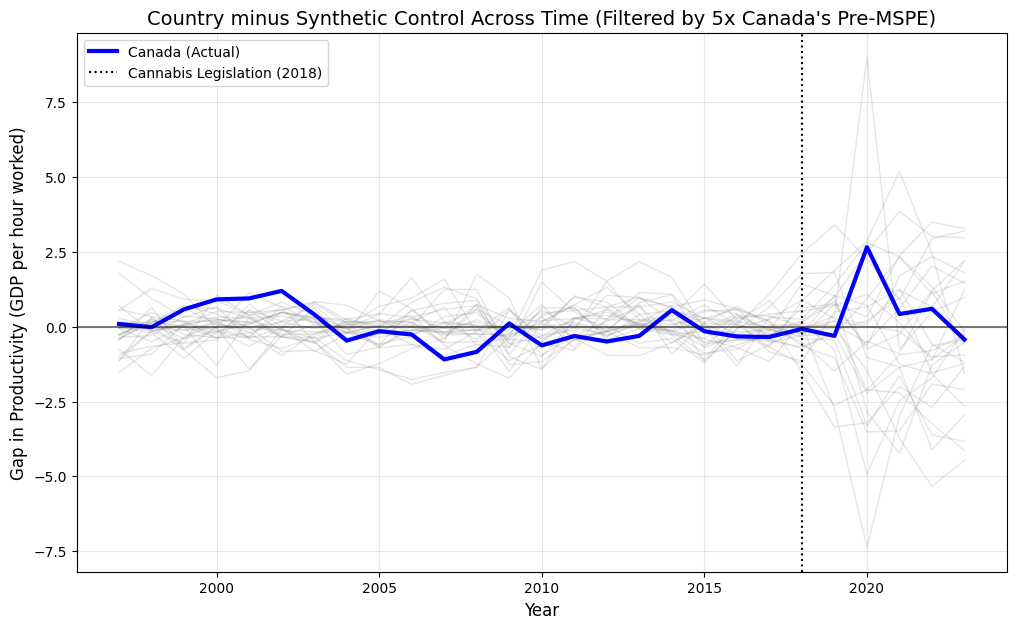

In [20]:
# Filtered by 5x Canada's Pre-MSPE
mspe_threshold = 5 * pre_mspe_canada
filtered5_mspes = mspe_df[mspe_df['pre_mse'] <= mspe_threshold] # Filtered MSPEs whose pre_mse is less than 5 times Canada's pre_mse

# 1. Plot Placebos Effects (Grey Lines)
placebo_countries = filtered5_mspes[filtered5_mspes['country'] != 'CAN']['country'] # Get donor countries that passed the MSPE filter
num_placebos = len(placebo_countries)
print(f"Number of placebo countries passing 2x MSPE filter: {num_placebos}")

plt.figure(figsize=(12, 7))
for country in placebo_countries:
    subset = all_placebos[all_placebos['country'] == country]
    plt.plot(subset['year'], subset['placebo_effect'], color='grey', alpha=0.2, linewidth=1)

# Plot Canada (Bold Blue)
canada_data = data[data['country'] == 'CAN']
plt.plot(canada_data['year'], canada_data['treatment_effect'], 
         color='blue', linewidth=3, label='Canada (Actual)')


plt.axvline(x=2018, color='black', linestyle=':', label='Cannabis Legislation (2018)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title("Country minus Synthetic Control Across Time (Filtered by 5x Canada's Pre-MSPE)", fontsize=14)
plt.ylabel("Gap in Productivity (GDP per hour worked)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

### Result 4 - Filtering Donors with 2x Canada's pre-MSPE 

Number of placebo countries passing 2x MSPE filter: 24


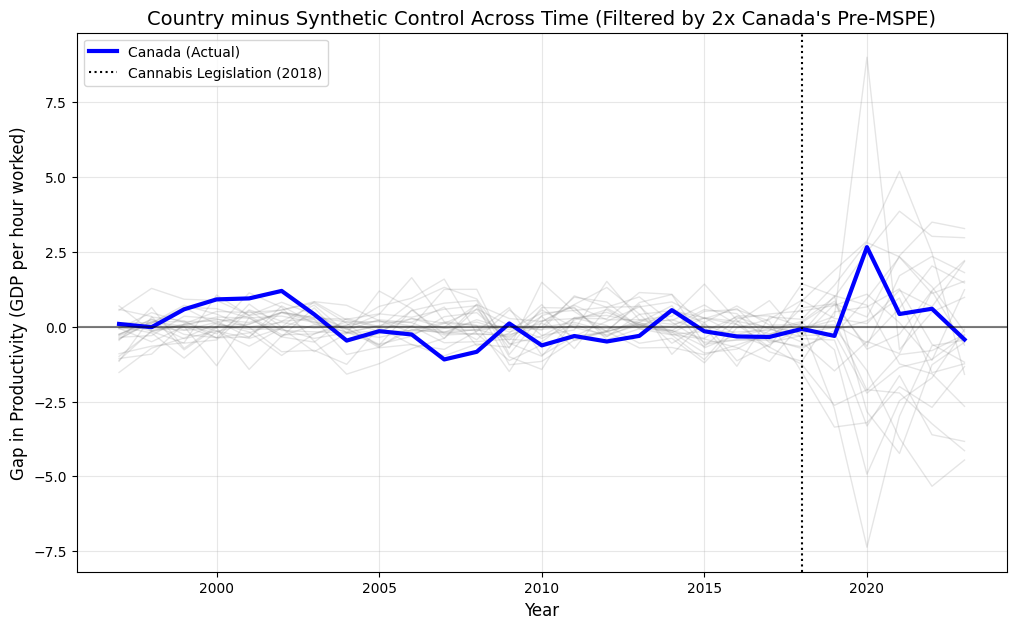

In [21]:
# Filtered by 2x Canada's Pre-MSPE
mspe_threshold = 2 * pre_mspe_canada
filtered2_mspes = mspe_df[mspe_df['pre_mse'] <= mspe_threshold] # Filtered MSPEs whose pre_mse is less than 2 times Canada's pre_mse

# 1. Plot Placebos Effects (Grey Lines)
placebo_countries = filtered2_mspes[filtered2_mspes['country'] != 'CAN']['country'] # Get donor countries that passed the MSPE filter
num_placebos = len(placebo_countries)
print(f"Number of placebo countries passing 2x MSPE filter: {num_placebos}")

plt.figure(figsize=(12, 7))
for country in placebo_countries:
    subset = all_placebos[all_placebos['country'] == country]
    plt.plot(subset['year'], subset['placebo_effect'], color='grey', alpha=0.2, linewidth=1)

# Plot Canada (Bold Blue)
canada_data = data[data['country'] == 'CAN']
plt.plot(canada_data['year'], canada_data['treatment_effect'], 
         color='blue', linewidth=3, label='Canada (Actual)')


plt.axvline(x=2018, color='black', linestyle=':', label='Cannabis Legislation (2018)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title("Country minus Synthetic Control Across Time (Filtered by 2x Canada's Pre-MSPE)", fontsize=14)
plt.ylabel("Gap in Productivity (GDP per hour worked)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# P-values (Facure's Method)

In [22]:
# empty vector to store values for post-treatment period
p_values = []
years_post = [2019, 2020, 2021, 2022, 2023]

for year in years_post:
    # Canada's effect
    can_effect = data[(data['country'] == 'CAN') & (data['year'] == year)]['treatment_effect'].values[0]
    
    # Get Placebo Effects 
    placebo_effects = all_placebos[
        (all_placebos['year'] == year) & 
        (all_placebos['country'].isin(unit_co))
    ]['placebo_effect'].values
    
    
    # one sided test to see if Canada's effect is larger than rest
    all_effects = np.append(placebo_effects, can_effect)
    
    # Calculate P-Value (textbook method)
    # Count how many effects (including Canada) are >= Canada's effect
    rank = np.sum(all_effects < can_effect)
    total_n = len(all_effects)
    p_val = rank / total_n
    
    p_values.append({
        'Year': year, 
        'Treatment Effect': can_effect,
        'Rank': f"{rank}/{total_n}", 
        'P-Value': p_val
    })

# Table to display results
results_df = pd.DataFrame(p_values)
print("\n--- P-Values ---")
print(results_df)


--- P-Values ---
   Year  Treatment Effect   Rank   P-Value
0  2019         -0.309131  11/36  0.305556
1  2020          2.656671  31/36  0.861111
2  2021          0.422231  22/36  0.611111
3  2022          0.597807  22/36  0.611111
4  2023         -0.428916  18/36  0.500000


## Distribution Effects
We show the distribution of MSPEs for the placebo countries and Canada for each year in the post-treatment period (2019-2023) to determine if Canada's treatment effect is extreme relative to the placebos.

### 2019

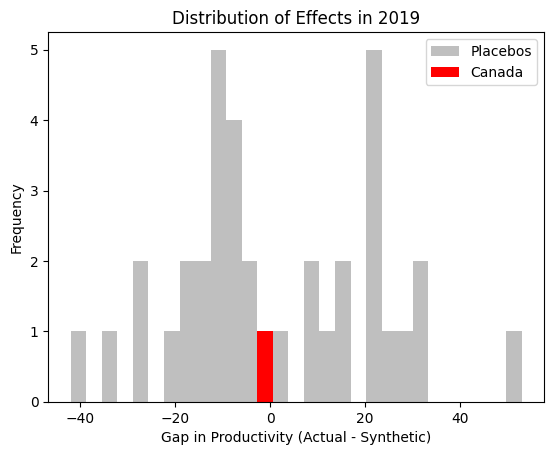

In [23]:
target_year = 2019

can_effect = data[
    (data['country'] == 'CAN') &
    (data['year'] == target_year)
]['treatment_effect'].values[0]

all_effect = data[
    (data['year'] == target_year) &
    (~data['country'].isin(['CAN']))
]
 # other than canada

# Compute bin range - troubleshooting since can_effect is negative in hist, manually changing range
xmin = min(all_effect['treatment_effect'].min(), can_effect)
xmax = max(all_effect['treatment_effect'].max(), can_effect)

bins = np.linspace(xmin, xmax, 30)

# placebo distribution
plt.hist(all_effect['treatment_effect'], bins=bins, color="gray", alpha=0.5, label="Placebos")

# Plot Canada effect
plt.hist([can_effect], bins=bins, color="red", label="Canada")

plt.ylabel("Frequency")
plt.xlabel("Gap in Productivity (Actual - Synthetic)")
plt.title(f"Distribution of Effects in {target_year}")
plt.legend()
plt.show()



### 2020

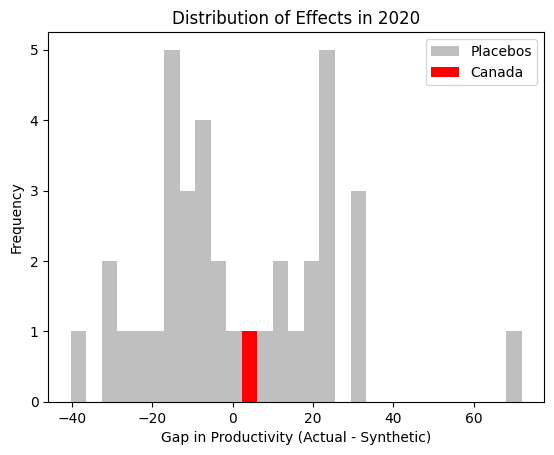

In [24]:
target_year = 2020

can_effect = data[
    (data['country'] == 'CAN') &
    (data['year'] == target_year)
]['treatment_effect'].values[0]

all_effect = data[
    (data['year'] == target_year) &
    (~data['country'].isin(['CAN']))
]
 # other than canada

# Compute bin range - troubleshooting since can_effect is negative in hist, manually changing range
xmin = min(all_effect['treatment_effect'].min(), can_effect)
xmax = max(all_effect['treatment_effect'].max(), can_effect)

bins = np.linspace(xmin, xmax, 30)

# placebo distribution
plt.hist(all_effect['treatment_effect'], bins=bins, color="gray", alpha=0.5, label="Placebos")

# Plot Canada effect
plt.hist([can_effect], bins=bins, color="red", label="Canada")

plt.ylabel("Frequency")
plt.xlabel("Gap in Productivity (Actual - Synthetic)")
plt.title(f"Distribution of Effects in {target_year}")
plt.legend()
plt.show()



### 2021

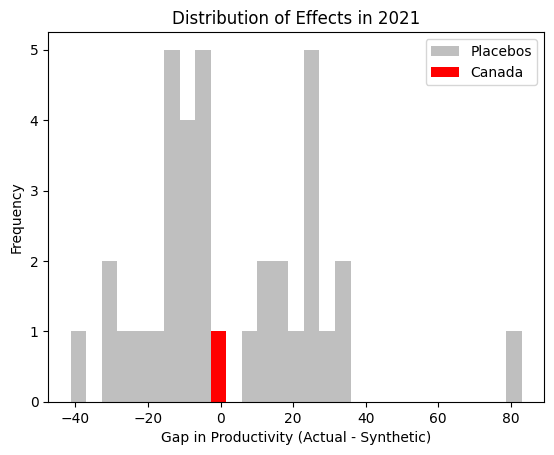

In [25]:
target_year = 2021

can_effect = data[
    (data['country'] == 'CAN') &
    (data['year'] == target_year)
]['treatment_effect'].values[0]

all_effect = data[
    (data['year'] == target_year) &
    (~data['country'].isin(['CAN']))
]
 # other than canada

# Compute bin range - troubleshooting since can_effect is negative in hist, manually changing range
xmin = min(all_effect['treatment_effect'].min(), can_effect)
xmax = max(all_effect['treatment_effect'].max(), can_effect)

bins = np.linspace(xmin, xmax, 30)

# placebo distribution
plt.hist(all_effect['treatment_effect'], bins=bins, color="gray", alpha=0.5, label="Placebos")

# Plot Canada effect
plt.hist([can_effect], bins=bins, color="red", label="Canada")

plt.ylabel("Frequency")
plt.xlabel("Gap in Productivity (Actual - Synthetic)")
plt.title(f"Distribution of Effects in {target_year}")
plt.legend()
plt.show()



### 2022

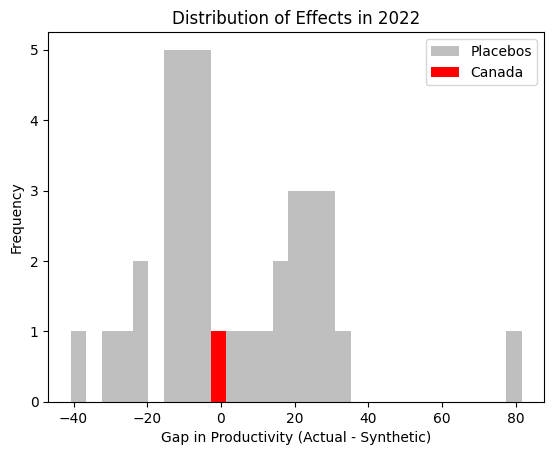

In [26]:
target_year = 2022

can_effect = data[
    (data['country'] == 'CAN') &
    (data['year'] == target_year)
]['treatment_effect'].values[0]

all_effect = data[
    (data['year'] == target_year) &
    (~data['country'].isin(['CAN']))
]
 # other than canada

# Compute bin range - troubleshooting since can_effect is negative in hist, manually changing range
xmin = min(all_effect['treatment_effect'].min(), can_effect)
xmax = max(all_effect['treatment_effect'].max(), can_effect)

bins = np.linspace(xmin, xmax, 30)

# placebo distribution
plt.hist(all_effect['treatment_effect'], bins=bins, color="gray", alpha=0.5, label="Placebos")

# Plot Canada effect
plt.hist([can_effect], bins=bins, color="red", label="Canada")

plt.ylabel("Frequency")
plt.xlabel("Gap in Productivity (Actual - Synthetic)")
plt.title(f"Distribution of Effects in {target_year}")
plt.legend()
plt.show()



### 2023

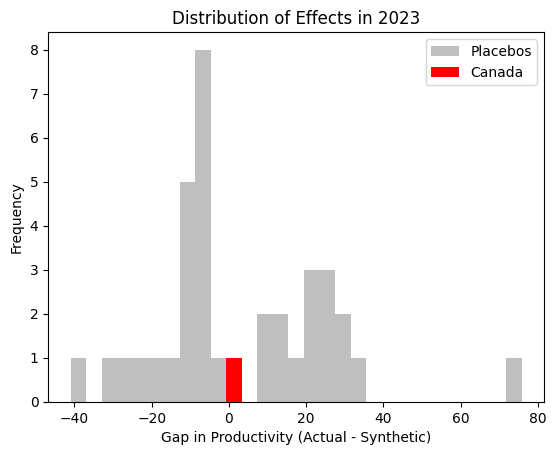

In [27]:
target_year = 2023

can_effect = data[
    (data['country'] == 'CAN') &
    (data['year'] == target_year)
]['treatment_effect'].values[0]

all_effect = data[
    (data['year'] == target_year) &
    (~data['country'].isin(['CAN']))
]
 # other than canada

# Compute bin range - troubleshooting since can_effect is negative in hist, manually changing range
xmin = min(all_effect['treatment_effect'].min(), can_effect)
xmax = max(all_effect['treatment_effect'].max(), can_effect)

bins = np.linspace(xmin, xmax, 30)

# placebo distribution
plt.hist(all_effect['treatment_effect'], bins=bins, color="gray", alpha=0.5, label="Placebos")

# Plot Canada effect
plt.hist([can_effect], bins=bins, color="red", label="Canada")

plt.ylabel("Frequency")
plt.xlabel("Gap in Productivity (Actual - Synthetic)")
plt.title(f"Distribution of Effects in {target_year}")
plt.legend()
plt.show()

